In [148]:
from IPython.display import display
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
error_calculation_metrics = ['mean_squared_error', 'mean_absolute_error']
ecm = error_calculation_metrics[1]

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

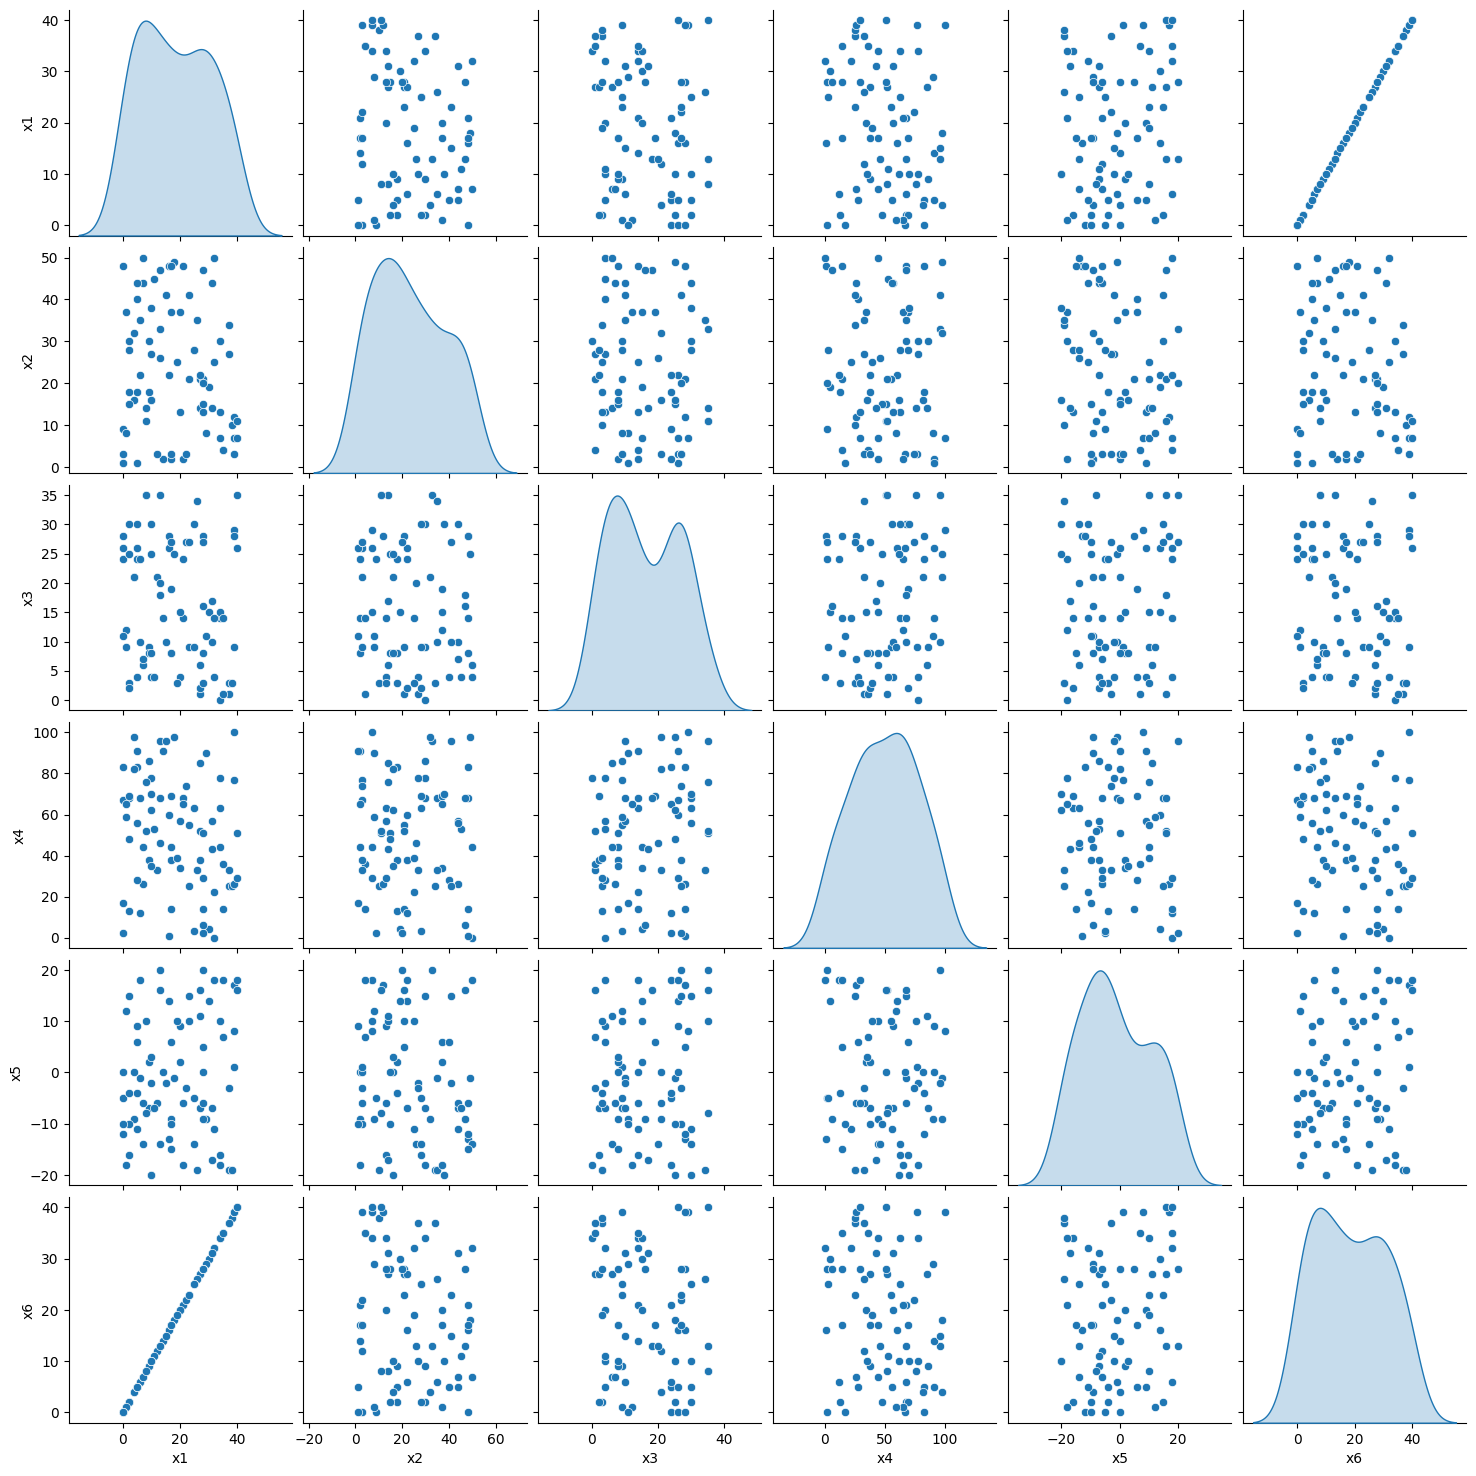

In [149]:
raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)


sns.pairplot(train_set[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], diag_kind='kde')

From looking at the results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same value twice.

Then, I wanted to see how each of those predictors relate to Y separately.

In [150]:
dataset = dataset.drop('x6', axis=1)
train_set = train_set.drop('x6', axis=1)
test_set = test_set.drop('x6', axis=1)

[<AxesSubplot:xlabel='x1', ylabel='Y'>,
 <AxesSubplot:xlabel='x2', ylabel='Y'>,
 <AxesSubplot:xlabel='x3', ylabel='Y'>,
 <AxesSubplot:xlabel='x4', ylabel='Y'>,
 <AxesSubplot:xlabel='x5', ylabel='Y'>]

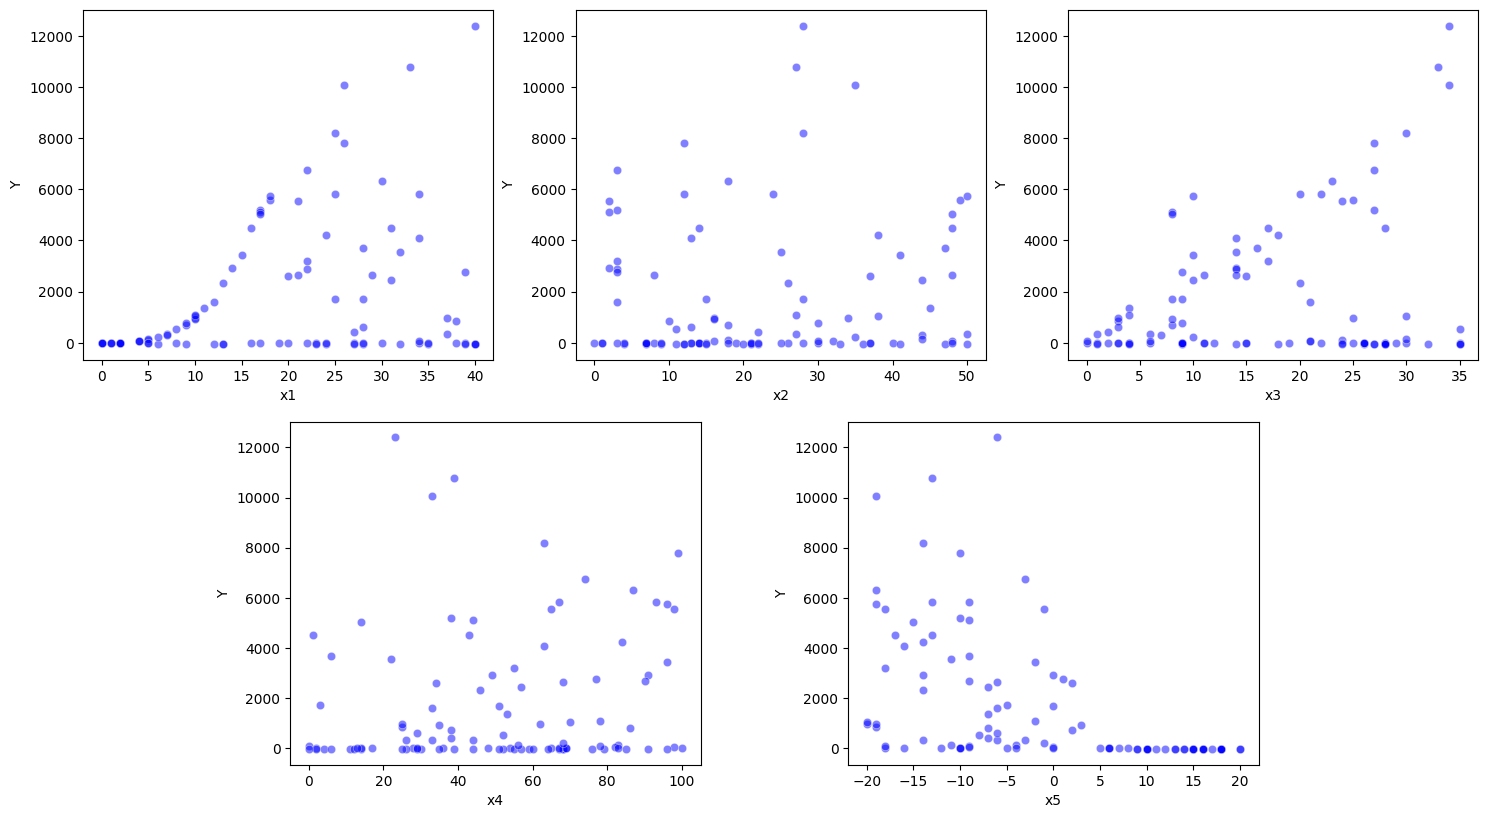

In [151]:
predictors = ['x1', 'x2', 'x3', 'x4', 'x5']

fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])
[sns.scatterplot(ax=axes_[i // 3, i % 3], x=dataset[predictors[i]], y=dataset['Y'], alpha=0.5, color='b')
 for i in range(len(predictors))]

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be low. Similarly,
when x5 has a value greater than 5, its corresponding Y value is very low.

The problem is, "very low" does not provide a clear metric,
so I have decided to examine "low" and "high" Y values separately.

<AxesSubplot:xlabel='SampleNo', ylabel='Y'>

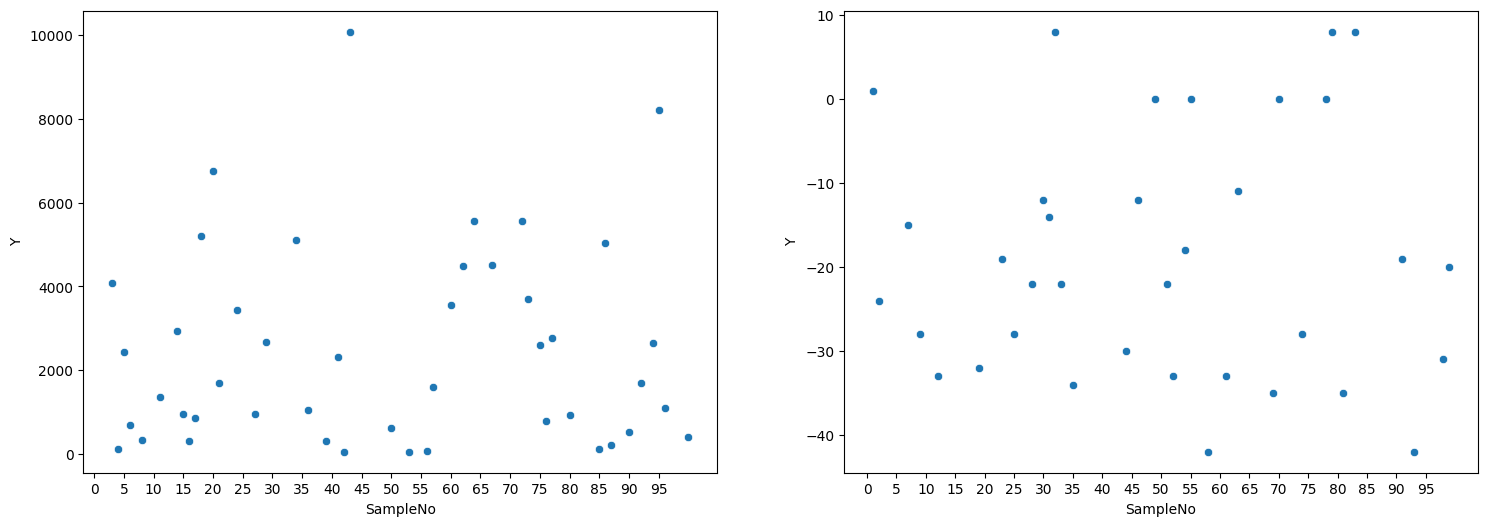

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.setp(axes, xticks=np.arange(0, 100, 5))

limit = 50
lt_limit = train_set.copy()
lt_limit.drop(lt_limit[lt_limit['Y'] <= limit].index, inplace=True)
gt_limit = train_set.copy()
gt_limit.drop(gt_limit[gt_limit['Y'] > limit].index, inplace=True)

sns.scatterplot(ax=axes[0], x=lt_limit['SampleNo'], y=lt_limit['Y'])
sns.scatterplot(ax=axes[1], x=gt_limit['SampleNo'], y=gt_limit['Y'])

Separating points with Y values that are less than 50 from those are greater than 50 give those plots. It is not clear
that which model would fit those points the best, but it would be odd if it was that easy.

In [153]:
train_features = train_set.copy()
test_features = test_set.copy()

train_labels = train_features.pop('Y')
test_labels = test_features.pop('Y')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
SampleNo,1.0,100.0,50.50,29.011492
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


# I. Single Linear Regression

## I.I. For x1

In [154]:
x1 = np.array(train_features['x1'])
x1_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
x1_normalizer.adapt(x1)

x1_model = tf.keras.Sequential([x1_normalizer, layers.Dense(units=1)])

display(x1_model.summary())

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_27 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_59 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


None

In [155]:
x1_model.predict(x1)
x1_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=ecm)

history = x1_model.fit(x=train_features['x1'],
                       y=train_labels,
                       epochs=200,
                       verbose=0,
                       validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

3/3 [==============================] - 0s 997us/step


,loss,val_loss,epoch
0,1290.816284,1789.835449,0
1,1290.704346,1789.733643,1
2,1290.607666,1789.680908,2
3,1290.538574,1789.683838,3
4,1290.481201,1789.685181,4
...,...,...,...
195,1287.858643,1784.348999,195
196,1287.842041,1784.319458,196
197,1287.836914,1784.282959,197
198,1287.825195,1784.249023,198


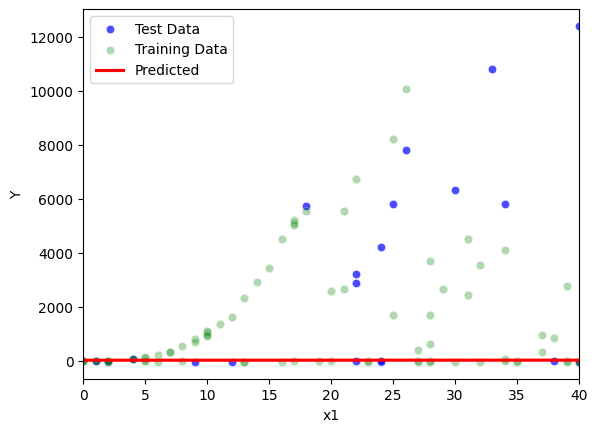

In [156]:
fig, ax = plt.subplots()
ax.set_xlim([table_heuristics['min']['x1'], table_heuristics['max']['x1']])

sns.scatterplot(ax=ax, x=test_features['x1'], y=test_labels,
                alpha=0.7, color='b', label='Test Data')
sns.scatterplot(ax=ax, x=train_features['x1'], y=train_labels,
                alpha=0.3, color='g', label='Training Data')

x = test_features['x1']
y_predict = x1_model.predict(x, verbose=0)

sns.regplot(ax=ax, x=test_features['x1'], y=y_predict[:,0],
            color='r', scatter=False, truncate=False, label='Predicted')

plt.xlabel('x1')
plt.ylabel('Y')
plt.legend()

## I.II. For Every Input Predictor

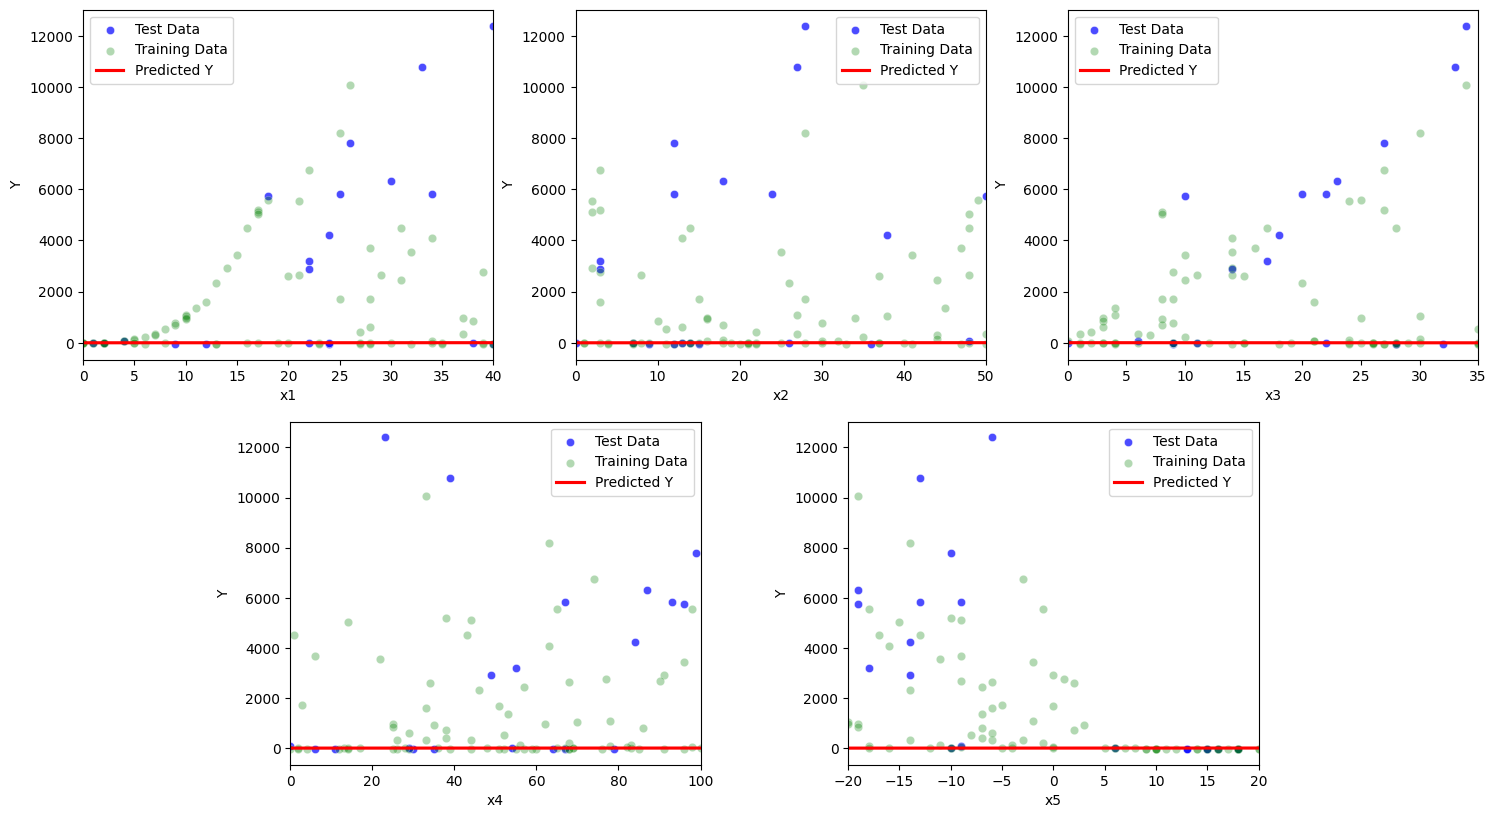

In [157]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

all_test_results = {}

ax_i = 0
xi_normalizer = layers.Normalization(input_shape=[1, ], axis=None)

for p in predictors:
    ax = axes[ax_i // 3, ax_i % 3]

    xi = np.array(train_features[p])
    xi_normalizer.adapt(xi)

    xi_model = tf.keras.Sequential([xi_normalizer, layers.Dense(units=1)])
    xi_model.predict(xi, verbose=0)
    xi_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=ecm)

    all_test_results[p] = xi_model.evaluate(test_features[p], test_labels, verbose=0)

    x = test_features[p]
    y_predict = xi_model.predict(x, verbose=0)

    sns.scatterplot(ax=ax, x=test_features[p], y=test_labels,
                    alpha=0.7, color='b', label='Test Data')
    sns.scatterplot(ax=ax, x=train_features[p], y=train_labels,
                    alpha=0.3, color='g', label='Training Data')
    sns.regplot(ax=ax, x=x, y=y_predict,
                color='r', scatter=False, label='Predicted Y', truncate=False)
    ax.set_xlim(table_heuristics['min'][p], table_heuristics['max'][p])
    ax.set_xlabel(p)
    ax.set_ylabel('Y')
    ax.legend()
    ax_i += 1

## II. Multiple Linear Regression

In [158]:
mul_linreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1)])

mul_linreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = mul_linreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['mul_linreg'] = mul_linreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1314.711670,1815.907959,0
1,1311.045288,1812.126953,1
2,1307.401611,1808.480957,2
3,1304.125244,1805.024414,3
4,1301.275146,1802.230591,4
...,...,...,...
995,1124.896729,1574.148804,995
996,1124.881592,1574.021606,996
997,1124.835571,1573.931641,997
998,1124.807983,1573.777588,998


<pre style="text-decoration: line-through"><b>Doesn't Make Sense</b>
fig, ax = plt.subplots()
ax.set_xlim([0,100])

sns.scatterplot(ax=ax, x=test_features['SampleNo'], y=test_labels, alpha=0.7, color='b', label='Test Data')
sns.scatterplot(ax=ax, x=train_features['SampleNo'], y=train_labels, alpha=0.3, color='g', label='Training Data')

y_predict = mul_linreg.predict(test_features[predictors])
y_comparison = pd.DataFrame({'Predicted': y_predict[:,0], 'Actual': test_labels})

display(y_comparison.transpose())

sns.regplot(ax=ax, x=y_comparison.index, y=y_comparison['Predicted'], color='r', scatter=False, truncate=False, label='Predicted')

ax.set_xlabel('SampleNo')
ax.set_ylabel('Y')
ax.legend()
</pre>

In [159]:
def display_error_table():
    display(pd.DataFrame([[k, v] for k,v in all_test_results.items()], columns=['model', ecm]))

display_error_table()

,model,mean_absolute_error
0,x1,3264.690186
1,x2,3264.456299
2,x3,3265.229980
3,x4,3264.689453
4,x5,3265.900391
5,mul_linreg,2933.971924


# III. Polynomial Regression

## III.I. Second Order Polynomial

In [160]:
sec_order_polyreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1, input_shape=[3])])

sec_order_polyreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = sec_order_polyreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['sec_order_polyreg'] = sec_order_polyreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1284.388062,1775.016357,0
1,1283.340332,1774.087158,1
2,1282.613525,1773.237061,2
3,1281.892212,1772.495850,3
4,1281.212158,1771.749023,4
...,...,...,...
995,1124.075562,1571.077148,995
996,1124.024902,1570.962402,996
997,1123.992188,1570.826660,997
998,1123.963379,1570.748901,998


<pre style="text-decoration: line-through"><b>Doesn't Make Sense</b>
y_predict = sec_order_polyreg.predict(test_features[predictors])
pred_results = pd.DataFrame({'Predicted': y_predict[:, 0], 'SampleNo': test_features['SampleNo']})

display(pred_results.transpose())

fig = sns.lmplot(data=pred_results, x='SampleNo', y='Predicted', order=2, scatter=False, truncate=False)
fig.set(xlim=(0, 100))

sns.scatterplot(x=test_features['SampleNo'], y=test_labels, alpha=0.7, color='b', label='Test Data')
sns.scatterplot(x=train_features['SampleNo'], y=train_labels, alpha=0.3, color='g', label='Training Data')

ax.set_xlabel('SampleNo')
ax.set_ylabel('Y')
ax.legend()
</pre>

## III.II. Third Order Polynomial

In [161]:
thr_order_polyreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1, input_shape=[4])])

thr_order_polyreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = thr_order_polyreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['thr_order_polyreg'] = thr_order_polyreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1318.943481,1808.247314,0
1,1314.576782,1804.346191,1
2,1310.240723,1800.521729,2
3,1306.171875,1797.185181,3
4,1302.541870,1793.918945,4
...,...,...,...
995,1122.205322,1569.411499,995
996,1122.198486,1569.390137,996
997,1122.173706,1569.341553,997
998,1122.163208,1569.256592,998


<pre style="text-decoration: line-through"><b>Doesn't Make Sense</b>
y_predict = thr_order_polyreg.predict(test_features[predictors])
pred_results = pd.DataFrame({'Predicted': y_predict[:, 0], 'SampleNo': test_features['SampleNo']})

display(pred_results.transpose())

fig = sns.lmplot(data=pred_results, x='SampleNo', y='Predicted', order=3, scatter=False, truncate=False)
fig.set(xlim=(0, 100))

sns.scatterplot(x=test_features['SampleNo'], y=test_labels, alpha=0.7, color='b', label='Test Data')
sns.scatterplot(x=train_features['SampleNo'], y=train_labels, alpha=0.3, color='g', label='Training Data')

ax.set_xlabel('SampleNo')
ax.set_ylabel('Y')
ax.legend()
</pre>

In [162]:
display_error_table()

,model,mean_absolute_error
0,x1,3264.690186
1,x2,3264.456299
2,x3,3265.229980
3,x4,3264.689453
4,x5,3265.900391
5,mul_linreg,2933.971924
6,sec_order_polyreg,2930.438965
7,thr_order_polyreg,2928.875244


In [163]:
def k_nearest_regression(k=3):

    def euclidean_dist(p_x, p_y):
        distances = list(map(lambda pr: (p_x[pr] - p_y[pr]) ** 2, predictors))
        return sum(distances)

    predictions = []

    for i in range(len(test_features.index)):
        current_row = test_features.iloc[i]
        current_distances = [[train_labels.iloc[n], euclidean_dist(current_row, train_features.iloc[n])]
                             for n in range(len(train_features.index))]
        current_distances.sort(key=lambda n: n[1])
        k_nearest_avg = sum([n[0] for n in current_distances[:k]]) // k
        predictions.append(k_nearest_avg)

    y_comparison = {'actual': list(test_labels), 'predicted': predictions}

    k_error = 0
    for act, pred in zip(y_comparison['actual'], y_comparison['predicted']):
        k_error += abs(act - pred)

    return {'k': k, 'comparison': pd.DataFrame(y_comparison).transpose(), 'error': k_error/len(predictions)}

## IV. K-Nearest-Neighbor

In [164]:
knn_args = [2, 3, 4, 5]

k_nearest_results = [k_nearest_regression(k) for k in knn_args]
for knn_result in k_nearest_results:
    all_test_results[f'knn_(k={knn_result["k"]})'] = knn_result['error']

display_error_table()

,model,mean_absolute_error
0,x1,3264.690186
1,x2,3264.456299
2,x3,3265.229980
3,x4,3264.689453
4,x5,3265.900391
5,mul_linreg,2933.971924
6,sec_order_polyreg,2930.438965
7,thr_order_polyreg,2928.875244
8,knn_(k=2),2036.300000
9,knn_(k=3),1903.650000


# TESTING

In [177]:
from sklearn.linear_model import LogisticRegression

def calculate_mae(y_act, y_pred):
    test_error = 0
    for actual, predicted in zip(y_act, y_pred):
        test_error += abs(actual - predicted)
    return test_error/len(y_pred)

def log_reg():
    logistic_regression = LogisticRegression(max_iter=20000)
    logistic_regression.fit(train_features[predictors], train_labels)
    
    predictions = logistic_regression.predict(test_features[predictors])
    mae_error = calculate_mae(list(test_labels), predictions)

    y_comparison = {'actual': list(test_labels), 'predicted': predictions}
    return {'comparison': pd.DataFrame(y_comparison), 'error': mae_error}

results = log_reg()
display(results['comparison'].transpose())
all_test_results['log_reg'] = results['error']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
actual,-13.0,4222.0,-37.0,-32.0,-33.0,2897.0,65.0,-25.0,-29.0,7804.0,10792.0,6315.0,5817.0,-25.0,-39.0,1.0,5812.0,12402.0,5733.0,3204.0
predicted,-18.0,5564.0,-33.0,-31.0,-19.0,5114.0,319.0,-19.0,-19.0,2667.0,10077.0,2667.0,4092.0,932.0,-35.0,0.0,2667.0,-35.0,789.0,5552.0


In [178]:
display_error_table()

,model,mean_absolute_error
0,x1,3264.690186
1,x2,3264.456299
2,x3,3265.229980
3,x4,3264.689453
4,x5,3265.900391
5,mul_linreg,2933.971924
6,sec_order_polyreg,2930.438965
7,thr_order_polyreg,2928.875244
8,knn_(k=2),2036.300000
9,knn_(k=3),1903.650000


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def polynomial_regression(order=2):
    poly_features = PolynomialFeatures(degree=order, include_bias=False)
    poly_train_features = poly_features.fit_transform(train_features[predictors])

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_train_features, train_labels)

    predictions = poly_reg_model.predict(poly_features.fit_transform(test_features[predictors]))

    mae_error = calculate_mae(list(test_labels), predictions)
    print(mae_error)

polynomial_regression(order=2)

1432.1452611683112


# APPLY K FOLD CROSS VALIDATION